### Final Project

1. orientation
2. velocity

set body length to 1 unit, pool size about 1000x body size?
Notemigonus crysoleucas (golden shiner) and Gambusia holbrooki (mosquitofish)
cap the max velocity at like 50 cm/s so like 10 bodylength per seconds

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
from matplotlib import colors

Initialization

In [233]:
N = 5 #number of fish
poolsize = 30 #relative to body length, maybe 1000
maxvelocity = 10 #bodylength per seconds

#init coordinations
motcoords = [(rng.randint(0,poolsize),rng.randint(0,poolsize)) for i in np.arange(N)]
xcoords, ycoords = zip(*motcoords)

#init orientations
motangles = [rng.randint(0,360) for i in np.arange(N)]
radmotangles = np.deg2rad(motangles)

#initialize velocity magnitude array
motvelmag = np.zeros(N)

#create a velocity (direction & magnitude) array
motvel = [(motvelmag[i]*np.cos(radmotangles[i]),motvelmag[i]*np.sin(radmotangles[i])) for i in np.arange(N)]


[(np.float64(0.0), np.float64(-0.0)),
 (np.float64(-0.0), np.float64(0.0)),
 (np.float64(-0.0), np.float64(0.0)),
 (np.float64(-0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(-0.0))]

Rule setting

In [228]:
#get distance to each neighbor

def finddistances(myindex, mycoord, coordarray):
    distances = [np.linalg.norm(np.subtract(mycoord, coordarray[i])) if i != myindex else np.nan for i in np.arange(len(coordarray))]
    return distances

#first find and index nearest neighbor
testcoord = (0,0)
coords = [(0,0), (1,0), (2,0), (0,3), (-4,3)]

def findnearestneighbor(myindex, mycoord, coordarray):
    dist = finddistances(myindex, mycoord, coordarray)
    neighbor_index = np.nanargmin(dist)
    return neighbor_index, dist

In [236]:
#movement setting
#1. update acceleration (new velocity magnitude)
#2. update orientation
#3. update coordinate based on new velocity 
t = 1 #timestep doesn't have to be 1, since fish think faster than they move maybe this should be lower like 10-100 milliseconds
newmotcoords = [np.add(motcoords[i],motvel[i]*t) for i in np.arange(N)] # x = x+vt for all fish

[array([16.,  2.]),
 array([14.,  8.]),
 array([17., 21.]),
 array([23., 23.]),
 array([29., 19.])]

In [ ]:
#Speed rule 1, attractive over R (1 body length) 
#If the nearest neighbor is within 1 body length of the fish, the fish decelerates

Plot

[]

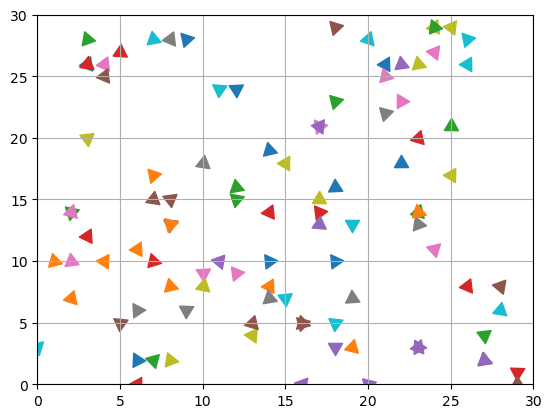

In [171]:
fig, ax = plt.subplots()
#scaling follows s = 125000/x^2 where x is the width of the coordinate

for i in np.arange(N):
    ax.scatter(xcoords[i],ycoords[i], marker = (3,0, motangles[i]), s = 125000/poolsize**2)

ax.set_xlim(0,poolsize)
ax.set_ylim(0,poolsize)
ax.grid()
plt.plot()


Analysis